# Piecewise Polytropic Example

To run this tutorial, you should install NEoST following the install guide. Some extra data files are also required, these are the `examples/J0740.npy` and `examples/GW170817.npy` files and are included in the GitHub repository along with this notebook.

Before continuing with this tutorial, please read the inference process overview to familiarise yourself with the way NEoST parametrises the equation of state.

The following block of code will properly import NEoST and its prerequisites, furthermore it also defines a name for the inference run, this name is what will be prefixed to all of NEoST's output files.

In [1]:
import neost
import kalepy
from neost.eos import polytropes, tabulated
from neost.Prior import Prior
from neost.Star import Star
from neost.Likelihood import Likelihood
from neost import PosteriorAnalysis
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib
from matplotlib import pyplot
from pymultinest.solve import solve
import time
import os

import neost.global_imports as global_imports

import warnings
warnings.filterwarnings('ignore')

# Some physical constants
c = global_imports._c
G = global_imports._G
Msun = global_imports._M_s
pi = global_imports._pi
rho_ns = global_imports._rhons

# Define name for run, extra - at the end is for nicer formatting of output
run_name = "PP-example-run-"

using c code


## Equation of state object
With NEoST properly imported the equation of state needs to be defined. For the PP parametrisation this is done by creating a `polytropes.PolytropicEoS()` object. This object takes as input the `crust` parameter, the `rho_t` parameter. 

Valid input for the crust parameter consists of one of the following values: `'ceft-Hebeler'`, `'ceft-Tews'`, `'ceft-Lynn'`, `'ceft-Drischler'`, `'ceft-old'` or `None`. This instructs NEoST on which cEFT model to use, in order of listing these would be: the band based on the work by Hebeler et al., Tews et al., Lynn et al., Drischler et al., an old implementation of the Hebeler band from Raaijmakers et al., or no cEFT at all.

The `rho_t` parameter tells NEoST at which density to transition between the cEFT crust parametrisation and the core parametrisation. This value must not exceed a value of twice the nuclear saturation density, although for the currently implemented cEFT models it should not exceed 1.1 times the nuclear saturation density.



In [2]:
# We're exploring a polytropic (PP) EoS parametrization with a chiral effective field theory (cEFT) parametrization based on Hebeler's work
# Transition between PP parametrisation and cEFT parametrization occurs at 1.1*saturation density
polytropes_pp = polytropes.PolytropicEoS(crust = 'ceft-Hebeler', rho_t = 1.1*rho_ns)

This block of code defines the measurements used to create the likelihood function for the Bayesian analysis. It shows you how to define measurements for both SciPy and KalePy, as well as what parameters need to be past for a mass-radius measurement and for a gravitational wave event when using non-synthetic data.

To define a mass-radius measurement you need to create a KDE object. For both KalePy and SciPy, you need to provide the samples from which to create the KDE. These samples need to be provided as an array of shape `(2,n)` where `n` is the number of samples of your dataset. The first row should consist of the masses and the second row should consist of the radii. As shown in the example, to turn a dataset into a SciPy KDE consists of simply calling the `gaussian_kde()` function and providing the dataset as argument.

To define a gravitational wave event you again have to create a KDE, again the format of the dataset is the same for both a KalePy and a SciPy KDE, but this time the array needs to have a shape of `(4,n)` where `n` again is the number of samples in your dataset. Here the rows correspond to the following quantities respectively:
- The chirp mass $M_c$
- The mass ratio $Q$
- The tidal deformability of the primary $\Lambda_1$
- The tidal deformability of the secondary $\Lambda_2$

For the purposes of this example script we now turn this dataset into a KalePy KDE. We do this by creating a `kalepy.KDE()` object which takes as first argument your dataset, as second argument you provide the reflection bounds of your KDE for each row in your dataset, where `None` indicates no reflection. The `weights` argument provides the weights of your dataset, if your dataset is equally-weighted you do not need to provide this argument. The `bandwidth` parameter allows you to tweak the width of the kernels in your KDE and the `kernel` argument allows you to specify which kernel you want to use.

In [3]:
# Create the likelihoods for the individual measurements
# First we load the mass-radius measurement
mass_radius_j0740 = np.load('../../examples/j0740.npy').T
print(mass_radius_j0740[0])
J0740_LL = gaussian_kde(mass_radius_j0740)
# And next up is the gravitational wave event
GW170817 = np.load('../../examples/GW170817.npy')
print(GW170817.shape)
GW170817_LL = kalepy.KDE(GW170817[:,0:4].T, reflect=[[None, None], [None, 1.], [0., None], [0., None]], weights=GW170817[:,4], bandwidth=0.1, kernel='gaussian')

[[ 3.31899211e-08 -2.86285105e-09  1.54277496e-04  3.21942472e-04]
 [-2.86285105e-09  7.09883592e-05  7.53025316e-02 -2.61180844e-02]
 [ 1.54277496e-04  7.53025316e-02  1.17142758e+03 -3.44084041e+02]
 [ 3.21942472e-04 -2.61180844e-02 -3.44084041e+02  2.55366529e+03]]
 [11.95036522  0.87049944]]) exceeds tolerance (5.0)!


[2.17574594 2.07090014 2.09164163 ... 2.13092618 2.18066547 2.16990759]
(8078, 5)


Next, these KDEs need to be passed to NEoST, this is done through the `likelihood_functions` and `likelihood_params` lists. The first one is a list of all the (callable) KDEs, and the second one is a list of as many instances of `['Mass', 'Radius']` as you have mass-radius measurements. The ordering of this list matters insofar as that you need to put any mass-radius measurements first in the `likelihood_functions` list and any gravitational wave events second.

You will also need to define a `chirp_mass` list containing the median values of the chirp masses of your events, in case your event is a mass-radius measurement, enter `None` instead.

Finally you will also need to define how many events you pass to NEoST, a quick and easy way to do this is shown in the example code below.

In [4]:
# Pass the likelihoods to the solver
likelihood_functions = [J0740_LL, lambda points: GW170817_LL.density(np.array([points]).T, probability=True)[1][0]]
likelihood_params = [['Mass', 'Radius']]

# Define whether event is GW or not and define number of stars/events
chirp_mass = [None, 1.186]
number_stars = len(chirp_mass)

If instead you are using synthetic data, for example a 2-dimensional Gaussian distribution, you can define a function that calculates the likelihood directly and pass this on to NEoST as follows:
```python
# 2-dimensional approximation of the J0740 measurement
mu_M = 2.08
mu_R = 11.155
sigma_M = 0.07 
sigma_R = 0.1 # uncertainty in radius
J0740 = sps.multivariate_normal(mean=[muM, muR], cov=[[sigM, 0.0], [0.0, sigR]])

likelihood_functions = [J0740.pdf]
likelihood_params = [['Mass', 'Radius']]
```

With our data defined, the next step is to define both the prior and the likelihood function.

The prior is defined through a pair of dictionaries, `variable_params` and `static_params`. Here `variable_params` takes in the equation of state parameters that will be allowed to vary, and `static_params` will take in those that won't. Entries into `variable_params` should be formatted as follows: `'param_name':[lower_bound,upper_bound]`

Additionally, for each of the measurements you must also append a dictionary item `'rhoc_i':[14.6, 16]` to the end of `variable_params`, this parameter covers the central density of star i and needs to be appended for each star individually. Entries into `static_params` should be formatted in the following manner: `'param_name':value`.

Finally, the prior object must be created using the following function call:`neost.Prior.Prior(EOS, variable_params, static_params, chirp_masses)` where the `EOS` argument is the equation of state object that was created in the previous step. When this prior is called it will then uniformly sample sets of parameters from the defined parameter ranges.

The likelihood is defined by providing both the previously defined prior object and the likelihood functions defined in the previous codeblock. This is done with the following code: `likelihood = Likelihood(prior, likelihood_functions, likelihood_params, chirp_mass)`

In [5]:
# Define variable parameters, same prior as previous papers of Raaijmakers et al.
variable_params={'ceft':[polytropes_pp.min_norm, polytropes_pp.max_norm],'gamma1':[1.,4.5],'gamma2':[0.,8.],'gamma3':[0.5,8.],'rho_t1':[1.5,8.3],'rho_t2':[1.5,8.3]}
for i in range(number_stars):
	variable_params.update({'rhoc_' + str(i+1):[14.6, 16]})

# Define static parameters, empty dict because all params are variable 
static_params={}

# Define joint prior and joint likelihood
prior = Prior(polytropes_pp, variable_params, static_params, chirp_mass)
likelihood = Likelihood(prior, likelihood_functions, likelihood_params, chirp_mass)

After defining your prior and likelihood function, it is best practice to test your prior and likelihood function. This is done with the short loop in the code block below. This loop will for each iteration first take a sample from the prior, and then compute the corresponding likelihood of said prior sample and print the likelihood as output.

In [6]:
print("Bounds of prior are")
print(variable_params)
print("number of parameters is %d" %len(variable_params))

# Perform a test, this will draw 50 random points from the prior and calculate their likelihood
print("Testing prior and likelihood")
cube = np.random.rand(50, len(variable_params))
for i in range(len(cube)):
    par = prior.inverse_sample(cube[i])
    print(likelihood.call(par))
print("Testing done")

Bounds of prior are
{'ceft': [1.676, 2.814], 'gamma1': [1.0, 4.5], 'gamma2': [0.0, 8.0], 'gamma3': [0.5, 8.0], 'rho_t1': [1.5, 8.3], 'rho_t2': [1.5, 8.3], 'rhoc_1': [14.6, 16], 'rhoc_2': [14.6, 16]}
number of parameters is 8
Testing prior and likelihood
-1e+101
-1e+101
[-164.59967768]
-1e+101
-1e+101
-1e+101
[-9.74944462]
[-11.28028778]
[-428.01768963]
[-583.80079904]
-1e+101
-1e+101
-1e+101
-1e+101
[-9.40361811]
-1e+101
[-18.42133681]
[-22.3849222]
-1e+101
-1e+101
-1e+101
[-8.78187271]
-1e+101
-1e+101
-1e+101
[-118.08215912]
-1e+101
[-8.35406058]
[-582.22544267]
[-620.29387611]
[-11.1942004]
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
[-7.82292765]
[-199.71931079]
[-10.75542501]
-1e+101
[-13.51267608]
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
-1e+101
[-330.66600624]
Testing done


When finished with testing your likelihood and prior you can proceed to the actual inference process. This is done in the code block below. Warning: depending on the performance of your platform, this might be a very slow process. To make it slightly faster, we have decreased the number of live points and set a maximum number of iterations for this example. For a proper analysis, we would remove the max_iter argument and set, for example, n_live_points=1000.

In [7]:
# Then we start the sampling with MultiNest
start = time.time()
result = solve(LogLikelihood=likelihood.call, Prior=prior.inverse_sample, n_live_points=100, evidence_tolerance=0.1,
               n_dims=len(variable_params), sampling_efficiency=0.8, max_iter=100, outputfiles_basename='../../examples/chains/' + run_name, verbose=True)
end = time.time()
print(end - start)

  analysing data from ../../examples/chains/PP-example-run-.txt
58.98666191101074


Finally, NEoST also includes functionality to perform the first steps of posterior analysis. The first step in this process is to call the `PosteriorAnalysis.compute_auxiliary_data()` function with the code block below. This will generate as output a set of files that can subsequently be used with several additional plotting routines included in NEoST, or you can analyse these files on your own. For the following posterior analysis examples we use previously computed high-resolution MultiNest example outputs to avoid problems with too few samples. Note that computing the auxiliary data might take some time.

In [8]:
# Compute auxiliary data for posterior analysis
PosteriorAnalysis.compute_auxiliary_data('../../examples/chains_example/' + run_name, polytropes_pp, 
                                         variable_params, static_params, chirp_mass)

Total number of samples is 5244
|████████████████████████████████████████| 5244/5244 [100%] in 22:41.0 (3.85/s) 
sample too small for 2374161204816352.00
sample too small for 2583716733631498.50
sample too small for 2811768697974225.00
sample too small for 3059949687207196.00
sample too small for 3330036391323825.00
sample too small for 3623962320002086.50
sample too small for 3943831644306433.50
sample too small for 4291934260128778.50
sample too small for 4670762181205290.00
sample too small for 5083027379064073.00
sample too small for 5531681197617238.00
sample too small for 6019935481383572.00
sample too small for 6551285568595496.00
sample too small for 7129535313794352.00
sample too small for 7758824319047053.00
sample too small for 8443657568728348.00
sample too small for 9188937680019554.00
sample too small for 10000000000000000.00
sample too small for 1842069969326716.25
sample too small for 2004660422642880.50
sample too small for 2181601935337768.75
sample too small for 2374

This following plotting routine will create a cornerplot of all the parameters you have included in the `variable_params` dictionary

In [9]:
# Make some analysis plots
PosteriorAnalysis.cornerplot('../../examples/chains_example/' + run_name, variable_params)

This will plot the data you have used to define the likelihood. So these are the masses and radii of the neutron stars that have been included in the analysis. Note that this will also plot the masses and radii of any gravitational wave events included in the data.

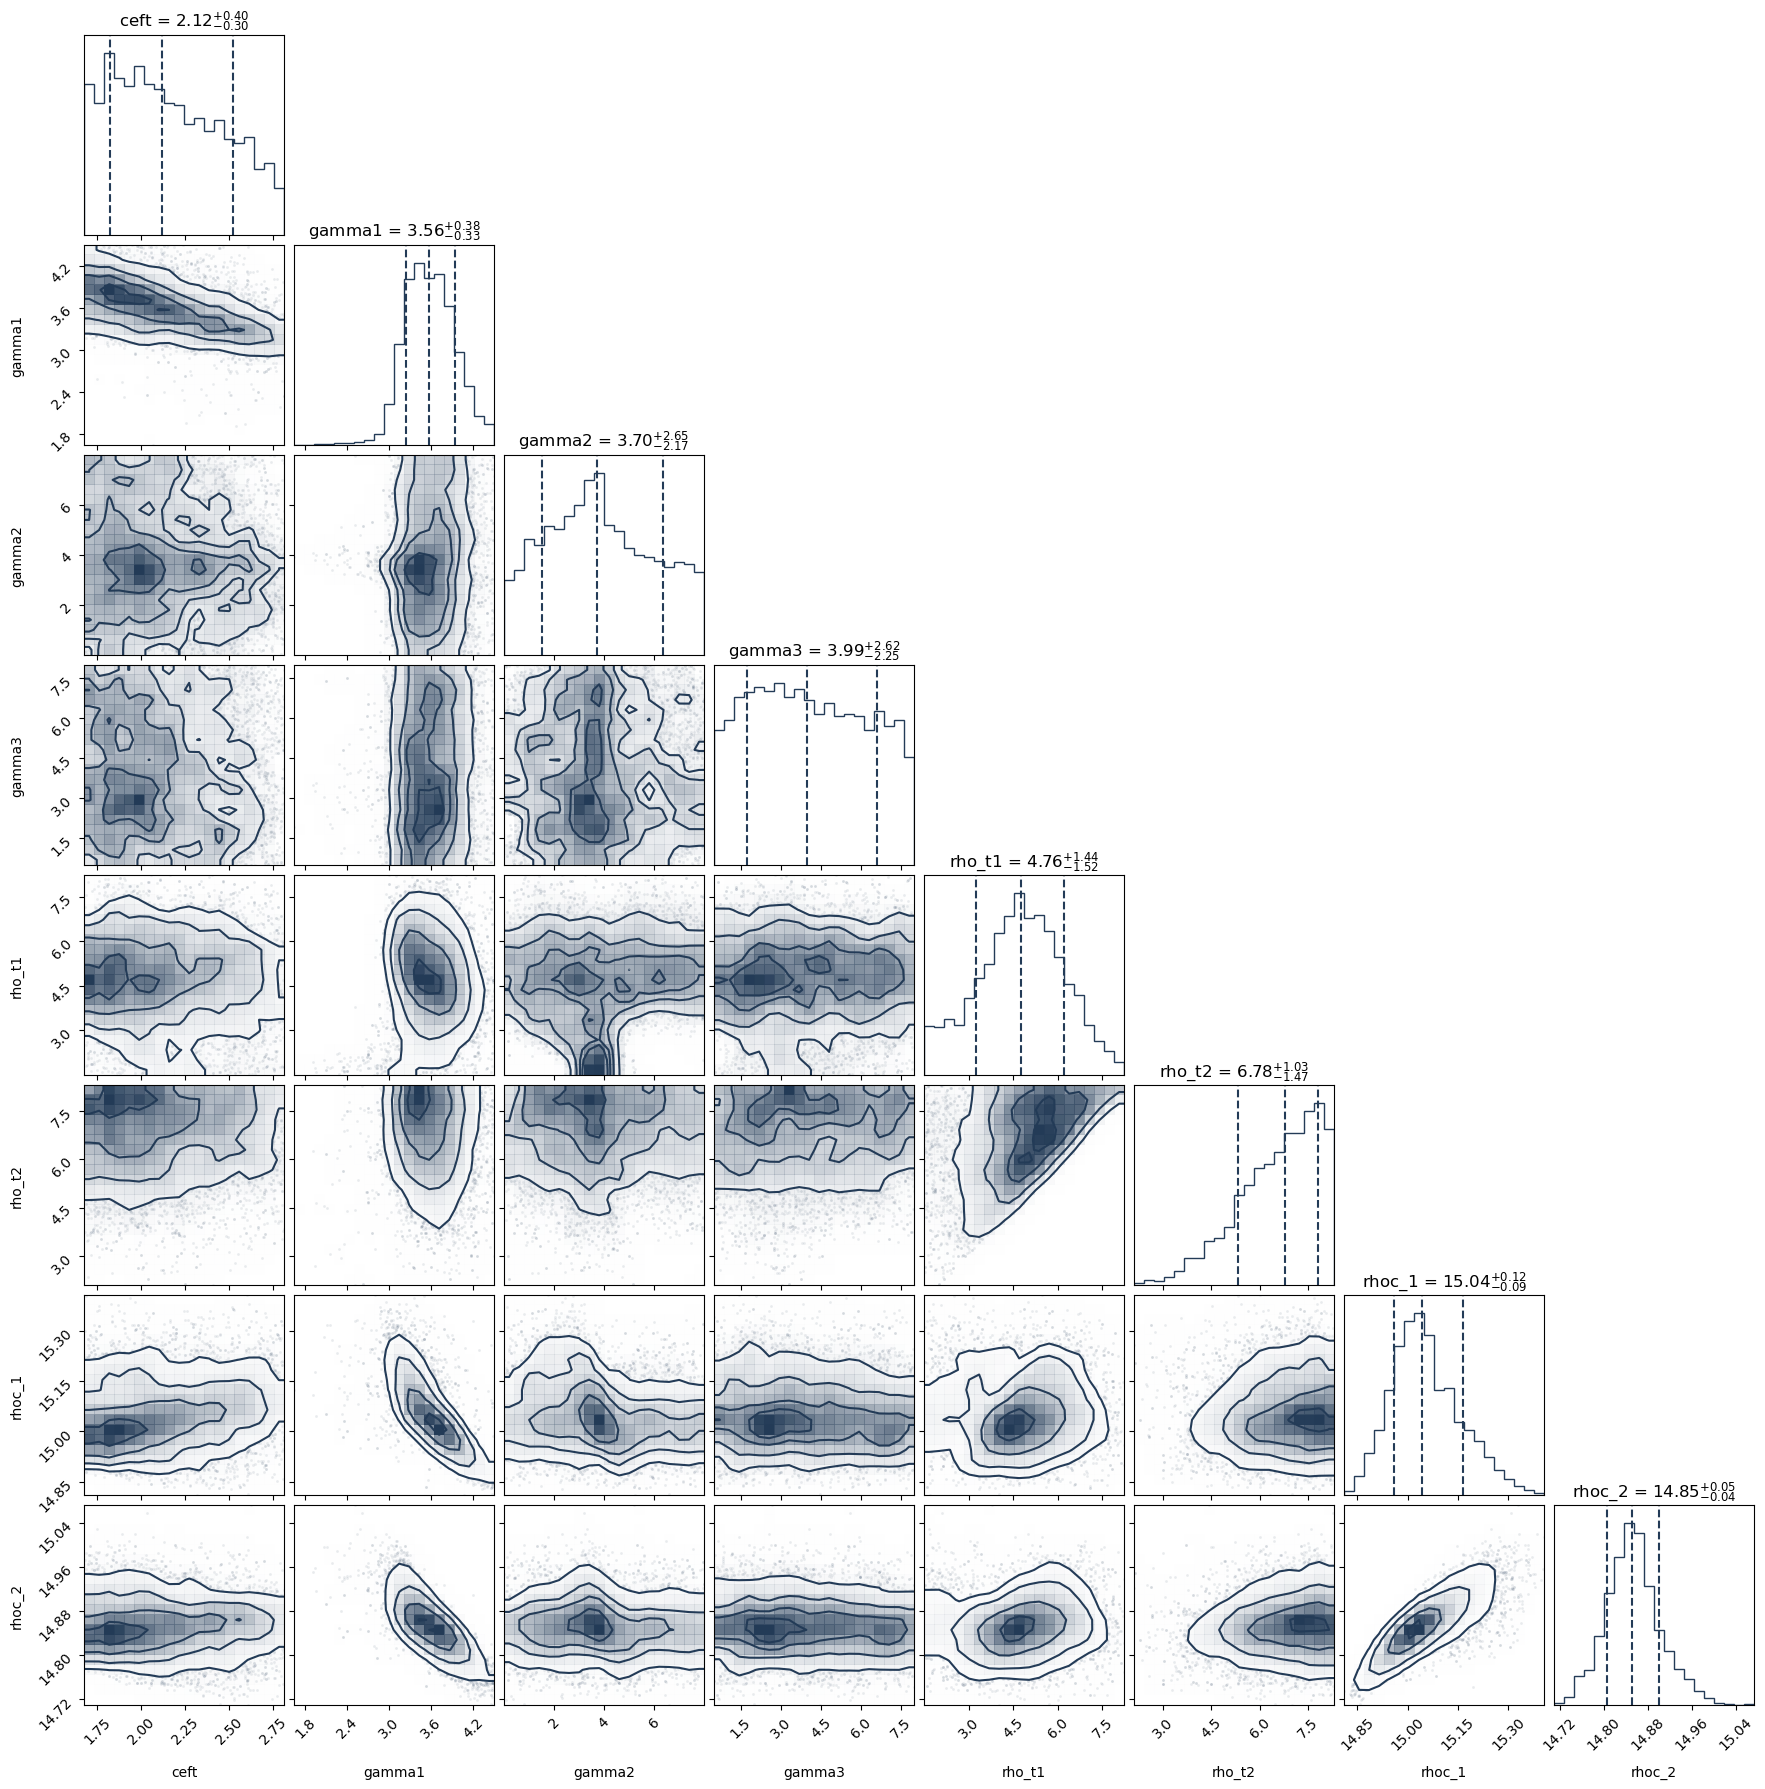

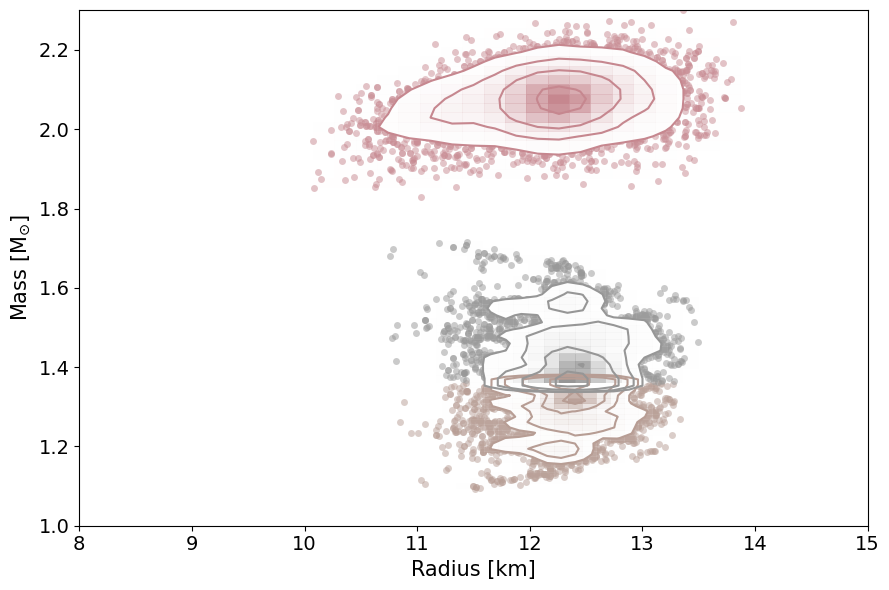

In [10]:
PosteriorAnalysis.mass_radius_posterior_plot('../../examples/chains_example/' + run_name)

This routine will plot the posterior on the mass-radius relationship of neutron stars according to the inference process, the `label_name` parameter will be the label used in the legend.

In [11]:
PosteriorAnalysis.mass_radius_prior_predictive_plot('../../examples/chains_example/' + run_name,variable_params, label_name='+ J0740 + GW170817')

This routine will plot the posterior on the equation of state itself.

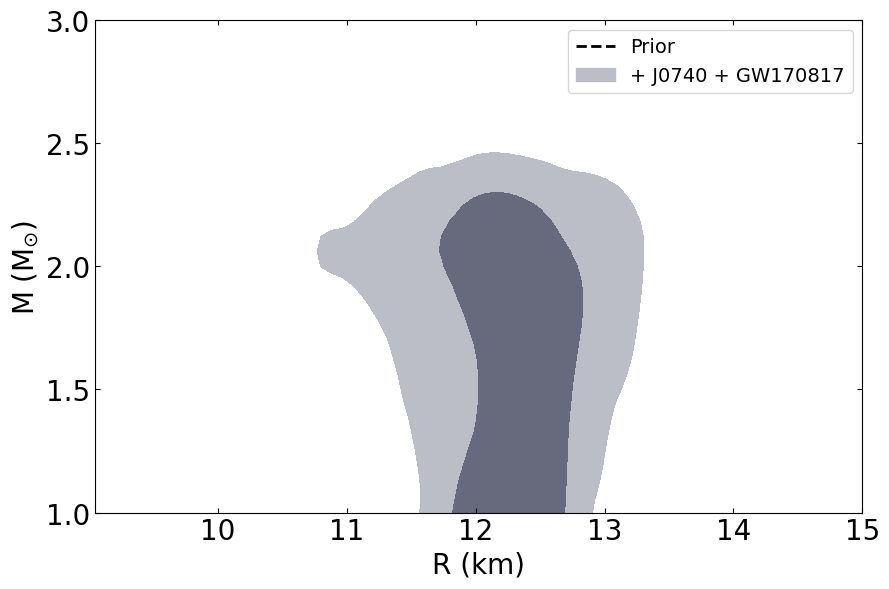

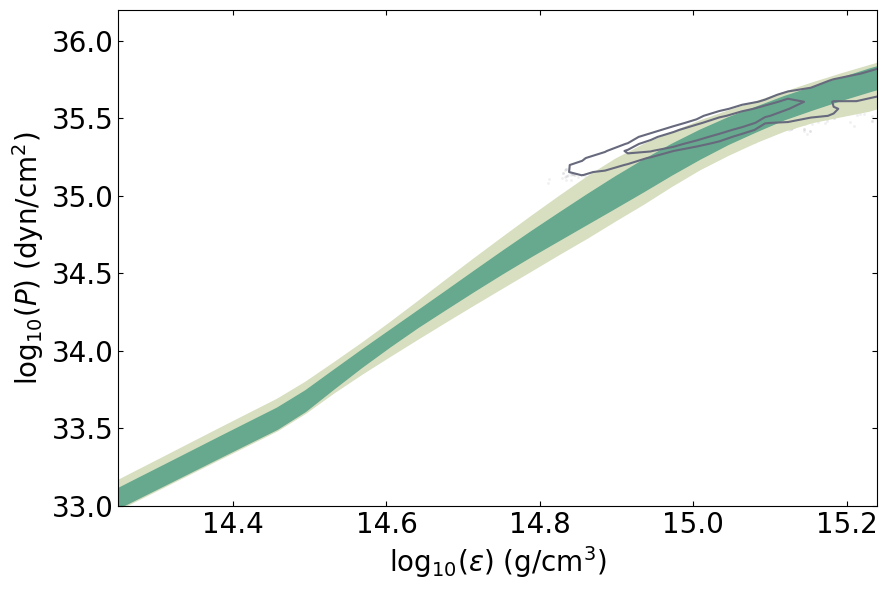

In [12]:
PosteriorAnalysis.eos_posterior_plot('../../examples/chains_example/' + run_name,variable_params)
pyplot.show()